<a href="https://colab.research.google.com/github/joacop01/Analisis-tiempo-frecuencia/blob/main/automatic_mask_generator_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/drive/17orK4ZCQTn8vx83yg8J4-38lMts5H0d9">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lguamk17
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lguamk17
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=ead88e5e23d38c8fdd337014b1eb9fa06d2800dff92b1d61deafe2224a668ff6
  Stored in directory: /tmp/pip-ephem-wheel-cache-h8drzuci/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-04-18 17:02:12--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Set-up

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
# Relevant modules
import numpy as np
import scipy.signal as sg
from scipy.fft import fft, ifft
from numpy import pi as pi

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0.35
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [6]:
import numpy as np
from numpy.fft import fft, ifft

# Función para obtener una ventana Gaussiana con el tamaño especificado
def get_gauss_window(Nfft, L, prec=1e-6):
    """
    Genera una ventana Gaussiana con un tamaño determinado.

    Args:
        Nfft (int): Número de puntos de la FFT.
        L (float): Parámetro de escala de la ventana Gaussiana.
        prec (float, opcional): Precisión de la ventana. Por defecto es 1e-6.

    Returns:
        g (ndarray): La ventana Gaussiana generada.
    """
    l = np.floor(np.sqrt(-Nfft * np.log(prec) / np.pi)) + 1
    N = 2 * l + 1
    t0 = l + 1
    tmt0 = np.arange(0, N) - t0
    g = np.exp(-(tmt0 / L) ** 2 * np.pi)
    g = g / np.linalg.norm(g)
    return g

# Función para obtener una ventana Gaussiana redonda para la STFT
def get_round_window(Nfft, prec=1e-6):
    """
    Genera una ventana Gaussiana redonda, es decir, con el mismo soporte esencial
    en tiempo y frecuencia, para el cálculo de la Transformada de Fourier de Corto Tiempo (STFT).

    Args:
        Nfft (int): Número de puntos de la FFT.
        prec (float, opcional): Precisión de la ventana. Por defecto es 1e-6.

    Returns:
        g (ndarray): La ventana Gaussiana generada.
        L (float): La escala de la ventana Gaussiana, calculada como L = sqrt(Nfft).
    """
    L = np.sqrt(Nfft)
    l = np.floor(np.sqrt(-Nfft * np.log(prec) / np.pi)) + 1

    N = 2 * l + 1
    t0 = l + 1
    tmt0 = np.arange(0, N) - t0
    g = np.exp(-(tmt0 / L) ** 2 * np.pi)
    g = g / np.linalg.norm(g)
    return g, L

# Función para calcular la STFT de una señal
def get_stft(x, window=None, t=None, Nfft=None):
    """
    Calcula la Transformada de Fourier de Tiempo Corto (STFT) de una señal.

    Args:
        x (ndarray): La señal de entrada.
        window (ndarray, opcional): La ventana para la STFT.
        t (ndarray, opcional): Los índices de tiempo.
        Nfft (int, opcional): Número de puntos para la FFT.

    Returns:
        tfr (ndarray): La STFT de la señal.
    """
    xrow = len(x)

    if t is None:
        t = np.arange(0, xrow)

    if Nfft is None:
        Nfft = 2 * xrow

    if window is None:
        window, _ = get_round_window(Nfft)

    tcol = len(t)
    hlength = np.floor(Nfft / 4)
    hlength = int(hlength + 1 - np.remainder(hlength, 2))

    hrow = len(window)

    assert np.remainder(hrow, 2) == 1

    Lh = (hrow - 1) // 2
    tfr = np.zeros((Nfft, tcol), dtype=complex)
    for icol in range(0, tcol):
        ti = t[icol]
        tau = np.arange(-np.min([np.round(Nfft / 2), Lh, ti]), np.min([np.round(Nfft / 2), Lh, xrow - ti])).astype(int)
        indices = np.remainder(Nfft + tau, Nfft).astype(int)
        tfr[indices, icol] = x[ti + tau] * np.conj(window[Lh + tau]) / np.linalg.norm(window[Lh + tau])

    tfr = fft(tfr, axis=0)
    return tfr

# Función para calcular la ISTFT (inversa de la STFT)
def get_istft(tfr, window=None, t=None):
    """
    Calcula la inversa de la STFT para obtener la señal original.

    Args:
        tfr (ndarray): La STFT de la señal.
        window (ndarray, opcional): La ventana utilizada.
        t (ndarray, opcional): Los índices de tiempo.

    Returns:
        x (ndarray): La señal reconstruida.
    """
    N, NbPoints = tfr.shape
    tcol = len(t)
    hrow = len(window)
    Lh = (hrow - 1) // 2
    window = window / np.linalg.norm(window)
    tfr = ifft(tfr, axis=0)

    x = np.zeros((tcol,), dtype=complex)
    for icol in range(0, tcol):
        valuestj = np.arange(np.max([1, icol - N / 2, icol - Lh]), np.min([tcol, icol + N / 2, icol + Lh])).astype(int)
        for tj in valuestj:
            tau = icol - tj
            indices = np.remainder(N + tau, N).astype(int)
            x[icol] = x[icol] + tfr[indices, tj] * window[Lh + tau]

        x[icol] = x[icol] / np.sum(np.abs(window[Lh + icol - valuestj]) ** 2)
    return x

# Función para calcular el espectrograma de una señal
def get_spectrogram(signal, window=None, Nfft=None, t=None, onesided=True):
    """
    Calcula el espectrograma de una señal utilizando una ventana dada.

    Args:
        signal (ndarray): La señal de entrada.
        window (ndarray, opcional): La ventana utilizada para la STFT.
        Nfft (int, opcional): Número de puntos de la FFT.
        t (ndarray, opcional): Los índices de tiempo.
        onesided (bool, opcional): Si es True, devuelve el espectrograma de un solo lado (frecuencias positivas).

    Returns:
        S (ndarray): El espectrograma de la señal.
        stft (ndarray): La STFT de la señal.
    """
    N = np.max(signal.shape)
    if Nfft is None:
        Nfft = 2 * N

    if window is None:
        window, _ = get_round_window(Nfft)

    if t is None:
        t = np.arange(0, N)

    stft = get_stft(signal, window=window, t=t, Nfft=Nfft)

    if onesided:
        S = np.abs(stft[0:Nfft // 2 + 1, :]) ** 2
    else:
        S = np.abs(stft) ** 2
    return S, stft

# Función para encontrar los ceros del espectrograma
def find_zeros_of_spectrogram(S, return_qz=False):
    """
    Encuentra los ceros en el espectrograma.

    Args:
        S (ndarray): El espectrograma de la señal.
        return_qz (bool, opcional): Si es True, devuelve el mapa de ceros.

    Returns:
        pos (ndarray): Las posiciones de los ceros en las coordenadas normalizadas.
    """
    aux_S = np.zeros((S.shape[0] + 2, S.shape[1] + 2)) + np.inf
    aux_S[1:-1, 1:-1] = S
    S = aux_S
    aux_ceros = ((S <= np.roll(S, 1, 0)) &
                 (S <= np.roll(S, -1, 0)) &
                 (S <= np.roll(S, 1, 1)) &
                 (S <= np.roll(S, -1, 1)) &
                 (S <= np.roll(S, [-1, -1], [0, 1])) &
                 (S <= np.roll(S, [1, 1], [0, 1])) &
                 (S <= np.roll(S, [-1, 1], [0, 1])) &
                 (S <= np.roll(S, [1, -1], [0, 1])))
    [y, x] = np.where(aux_ceros == True)
    pos = np.zeros((len(x), 2))  # Position of zeros in norm. coords.
    pos[:, 0] = y - 1
    pos[:, 1] = x - 1

    if return_qz:
        return aux_ceros[1:-1, 1:-1]

    return pos

# Función para encontrar los máximos en el espectrograma
def find_max_of_spectrogram(S, return_qz=False):
    """
    Encuentra los máximos en el espectrograma.

    Args:
        S (ndarray): El espectrograma de la señal.
        return_qz (bool, opcional): Si es True, devuelve el mapa de máximos.

    Returns:
        pos (ndarray): Las posiciones de los máximos en las coordenadas normalizadas.
    """
    aux_S = np.zeros((S.shape[0] + 2, S.shape[1] + 2))
    aux_S[1:-1, 1:-1] = S
    S = aux_S
    aux_ceros = (
            (S >= np.roll(S, 1, 0)) &
            (S >= np.roll(S, -1, 0)) &
            (S >= np.roll(S, 1, 1)) &
            (S >= np.roll(S, -1, 1)) &
            (S >= np.roll(S, [-1, -1], [0, 1])) &
            (S >= np.roll(S, [1, 1], [0, 1])) &
            (S >= np.roll(S, [-1, 1], [0, 1])) &
            (S >= np.roll(S, [1, -1], [0, 1]))
            )
    [y, x] = np.where(aux_ceros == True)
    pos = np.zeros((len(x), 2))  # Position of zeros in norm. coords.
    pos[:, 0] = y - 1
    pos[:, 1] = x - 1

    if return_qz:
        return aux_ceros[1:-1, 1:-1]

    return pos

# Función para calcular el histograma de ceros para una señal dada
def d2_histogram(signal, J=256, beta=1.0, Nfft=None):
    """
    Calcula el histograma de ceros para una señal dada con ruido añadido.

    Args:
        signal (ndarray): La señal de entrada.
        J (int, opcional): Número de muestras de ruido. Por defecto es 256.
        beta (float, opcional): Factor de escala para el ruido. Por defecto es 1.0.
        Nfft (int, opcional): Número de puntos de la FFT.

    Returns:
        hist (ndarray): El histograma de ceros.
    """
    N = len(signal)
    S, stft = get_spectrogram(signal, Nfft=Nfft)
    absFr = np.abs(np.real(stft))
    stdAlgEst = np.sqrt(2) * np.median(absFr) / 0.6745

    Qz = find_zeros_of_spectrogram(S, return_qz=True).astype(int)
    hist = np.zeros_like(Qz)

    for j in range(J - 1):
        noise = np.random.randn(N,)
        noisy_signal = signal + noise * beta * stdAlgEst
        S, _ = get_spectrogram(noisy_signal, Nfft=Nfft)
        Qz = find_zeros_of_spectrogram(S, return_qz=True)
        hist += Qz.astype(int)

    return hist

# Función para reconstruir una señal a partir de su STFT y una máscara
def reconstruct_signal_3(stft, mask, window=None):
    """
    Reconstruye una señal a partir de su STFT y una máscara.

    Args:
        stft (ndarray): La STFT de la señal.
        mask (ndarray): La máscara que se aplica a la STFT.
        window (ndarray, opcional): La ventana utilizada para la reconstrucción.

    Returns:
        xr (ndarray): La señal reconstruida.
    """

    mask_complete = np.zeros_like(stft)
    mask_complete[0:mask.shape[0], :] = mask
    mask_complete[mask.shape[0]::, :] = mask[-2:0:-1, :]
    xr = get_istft(stft * mask_complete, window=window, t=np.arange(0, stft.shape[1]))
    return xr



# Función para añadir ruido a una señal para obtener una relación señal-ruido (SNR) deseada
def add_snr(x, snr, complex_noise=False):
    """
    Añade ruido a una señal para obtener una relación señal-ruido (SNR) deseada.

    Args:
        x (ndarray): La señal de entrada.
        snr (float): La relación señal-ruido deseada en dB.
        complex_noise (bool, opcional): Si es True, el ruido será complejo (real + imaginario).

    Returns:
        x (ndarray): La señal con ruido añadido.
        n (ndarray): El ruido añadido.
    """
    N = len(x)
    x = x - np.mean(x)
    Px = np.sum(x ** 2)

    # Crear el ruido para la señal con el SNR dado:
    n = np.random.randn(N,)
    if complex_noise:
        n = n.astype(complex)
        n += 1j * np.random.randn(N,)

    Pn = np.sum(np.abs(n) ** 2, axis=0)  # Normalizar la varianza del ruido a 1.
    n = n / np.sqrt(Pn)
    Pn = Px * 10 ** (- snr / 10)  # Darle al ruido la varianza prescrita.
    n = n * np.sqrt(Pn)

    snr_out = 10 * np.log10(Px / Pn)
    print('snr_out:{}'.format(snr_out))
    return x + n, n


In [34]:
def sam_filtering(signal,mascaras, Nfft=512, thr=0):
    """
    Realiza un filtrado basado en un espectrograma de la señal, utilizando un predictor para generar una máscara
    y reconstruir la señal filtrada.

    Args:
        signal (ndarray): La señal de entrada.
        Nfft (int, opcional): Número de puntos de la FFT para calcular el espectrograma. Por defecto es 512.
        thr (float, opcional): Umbral para el espectrograma. Los valores menores a este umbral se ponen a 0.

    Returns:
        tuple: Una tupla con:
            - mask (ndarray): Máscara generada por el predictor.
            - image (ndarray): Imagen del espectrograma normalizado.
            - xr (ndarray): Señal reconstruida utilizando la máscara.
    """
    N = len(signal)

    # Obtiene la ventana redonda y su escala
    g, L = get_round_window(Nfft,)

    # Calcula el espectrograma de la señal
    S, stft = get_spectrogram(signal, window=g, Nfft=Nfft)

    # Aplica el umbral al espectrograma
    S[S < thr] = 0

    # Normaliza el espectrograma entre 0 y 255 para crear una imagen
    S = (S - np.min(S)) / (np.max(S) - np.min(S))
    image = np.zeros((S.shape[0], S.shape[1], 3), dtype=np.float32)
    image[:, :, 0] = S
    image[:, :, 1] = S
    image[:, :, 2] = S

    masks = mask_generator.generate(image)

    xr = []
    for i in range (mascaras):
        mask = masks[i]['segmentation']
        xr.append(reconstruct_signal_3(stft, mask, window=g))

    # Reconstruye la señal filtrada utilizando la máscara


    return masks, image, xr



In [99]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.95,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=15000,  # Requires open-cv to run post-processing
)

## Example image

In [61]:
N = 1024
tmin = int(N**0.5)
tmax = N-int(N**0.5)
fmin=0.07
fmax=0.43
fmid = 0.25
Nsub = tmax-tmin
tsub = np.arange(Nsub)


# Cosenoidal Chirp 1
x1 = np.zeros(N)
omega1=1.5
a1=1.0,
f0=fmax-0.05,
a2=0.04
instf1 = f0 + a2*np.cos(2*pi*omega1*tsub/Nsub - pi*omega1)
phase1 = np.cumsum(instf1)
a1 = 1.0
x1[tmin:tmax] = a1*np.cos(2*pi*phase1)*sg.windows.tukey(Nsub,0.25)

# Cosenoidal Chirp 2
x2 = np.zeros(N)
omega2=1.8
a1=1.0,
f0=fmid
a2=0.04
instf2 = f0 + a2*np.cos(2*pi*omega2*tsub/Nsub - pi*omega2)
phase2 = np.cumsum(instf2)
x2[tmin:tmax] = a1*np.cos(2*pi*phase2)*sg.windows.tukey(Nsub,0.25)

signal_noiseless = np.zeros((N,))
signal_noiseless = x1+x2
signal, noise = add_snr(signal_noiseless,15)

snr_out:15.0


In [62]:
masks, image, xr = sam_filtering(signal, mascaras=3)

In [63]:
masks = masks[:3]

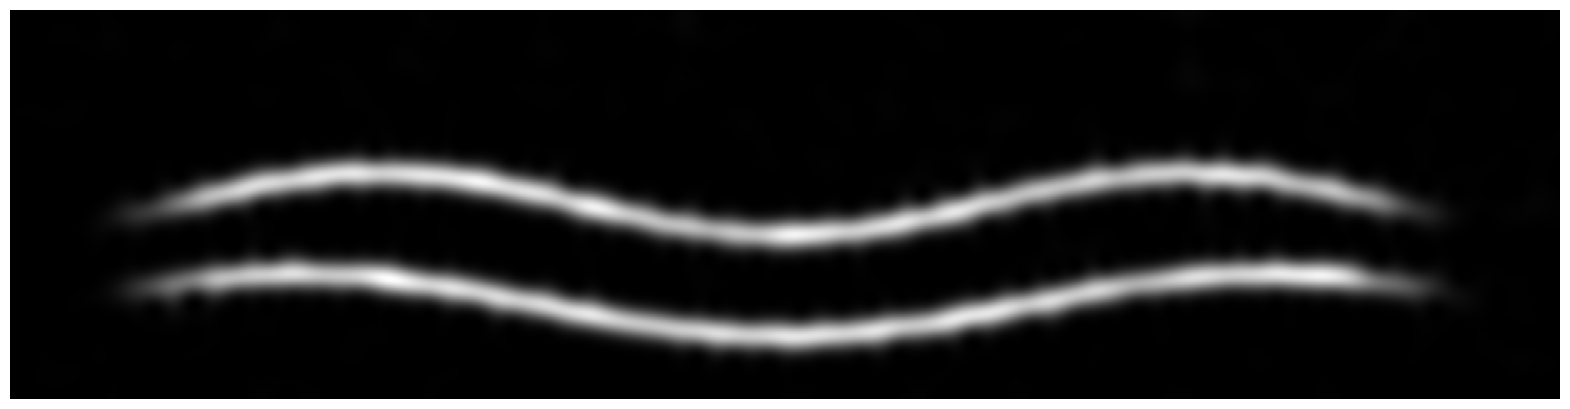

In [64]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

To generate masks, just run `generate` on an image.

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

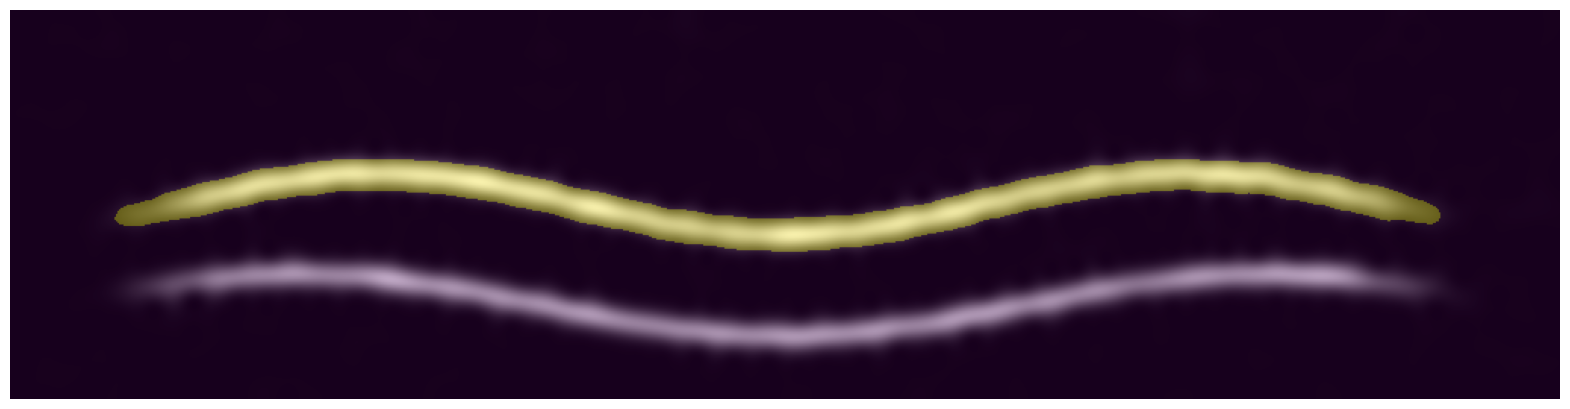

In [67]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.imshow(masks[1]['segmentation'], alpha = 0.35)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

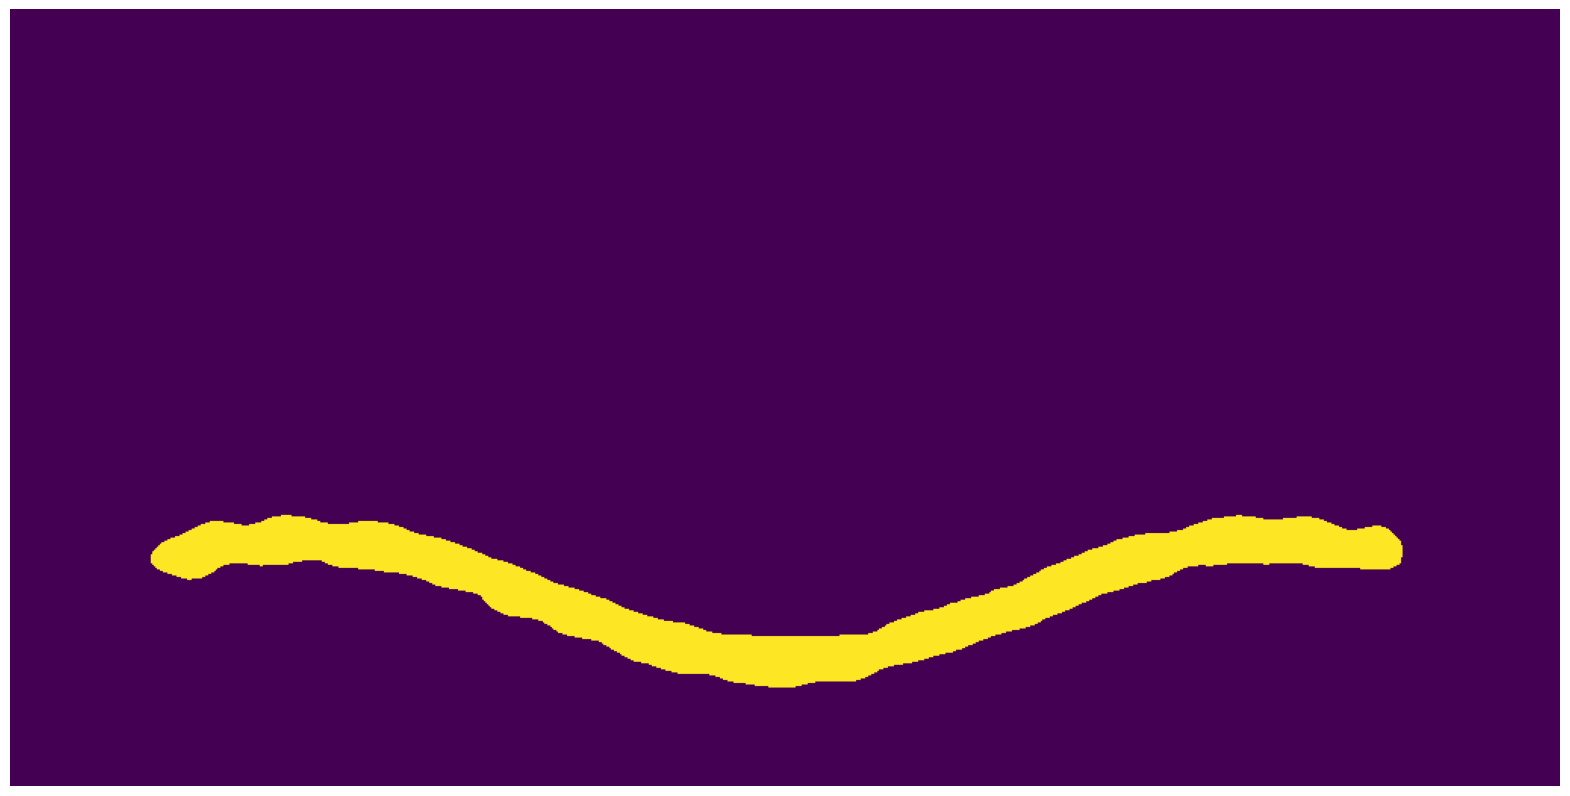

In [140]:
i = 5
j = 5
mascaras = all_masks[i][j]

plt.figure(figsize=(20,20))
plt.imshow(all_images[i][j])
plt.imshow(mascaras[0]['segmentation'])
plt.axis('off')
plt.show()

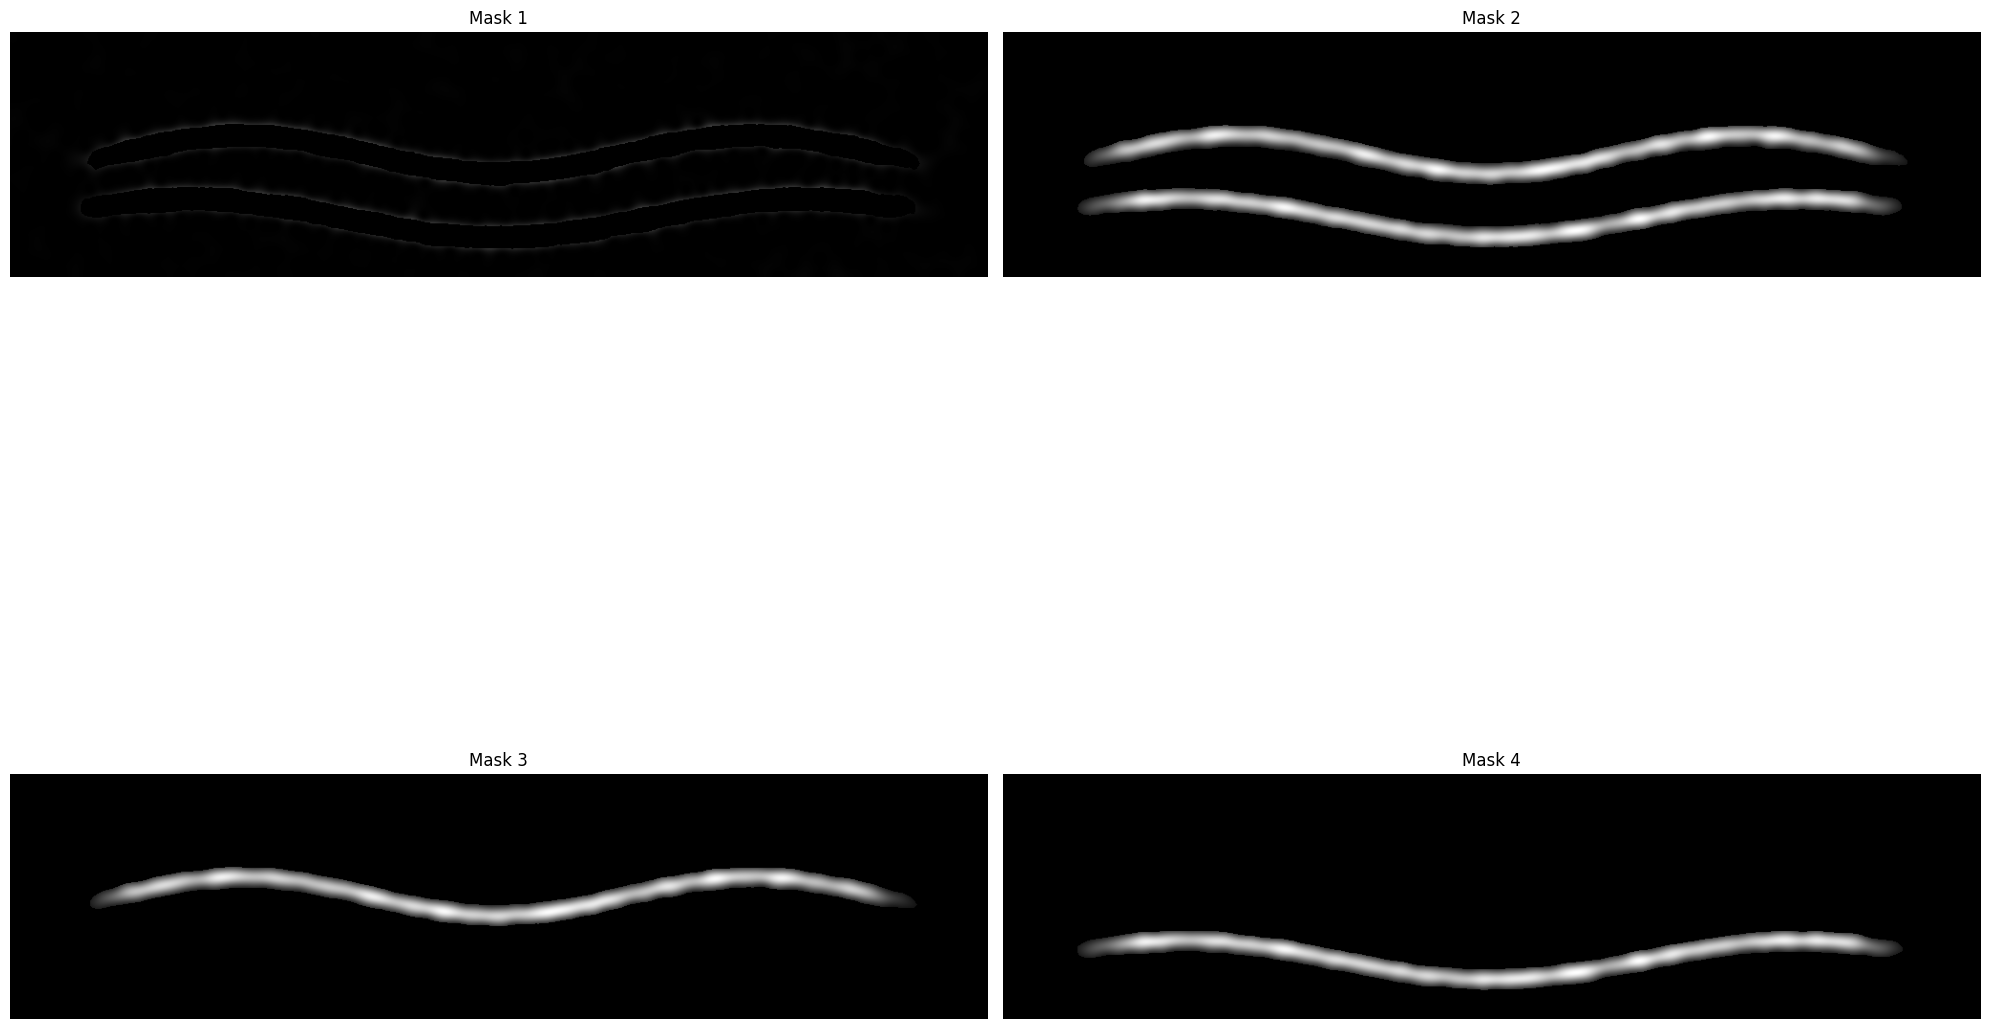

In [48]:
# prompt: quiero que cuando se muestra la mascara superpuesta con la imagen se diferencie cada una de las mascaras con marcas o labels, tambien quiero que realices una operacion booleana entre cada mascara y la imagen, y te quedes solo con la interseccion de cada una, y me muestres las 4 imagenes por separado

import matplotlib.pyplot as plt
import numpy as np

def show_anns_with_labels(anns, image):
    if len(anns) == 0:
        return

    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    fig, axes = plt.subplots(2, 2, figsize=(20, 20))  # Create a 2x2 grid of subplots
    axes = axes.ravel() # Flatten the array of axes

    for i, ann in enumerate(sorted_anns[:4]):  # Process only the first 4 masks
      m = ann['segmentation']
      color_mask = np.concatenate([np.random.random(3), [0.35]])
      img_with_mask = image.copy() # create a copy to avoid modifying the original image

      # Adjust color_mask shape to match img_with_mask channels
      img_with_mask[m] = color_mask[:3] # Select only the first 3 channels (RGB) from color_mask

      # Boolean operation: Intersection between mask and image
      intersection = np.logical_and(image, m[..., None]) # Add a new axis to m to align with image channels
      intersection = np.where(intersection, image, 0)


      axes[i].imshow(intersection) # Display the intersection
      axes[i].set_title(f'Mask {i+1}') # Set title with label
      axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# Assuming 'image' and 'masks' are defined from the previous code
show_anns_with_labels(masks2, image)

(0.7953671052385585+13.643763538418412j)


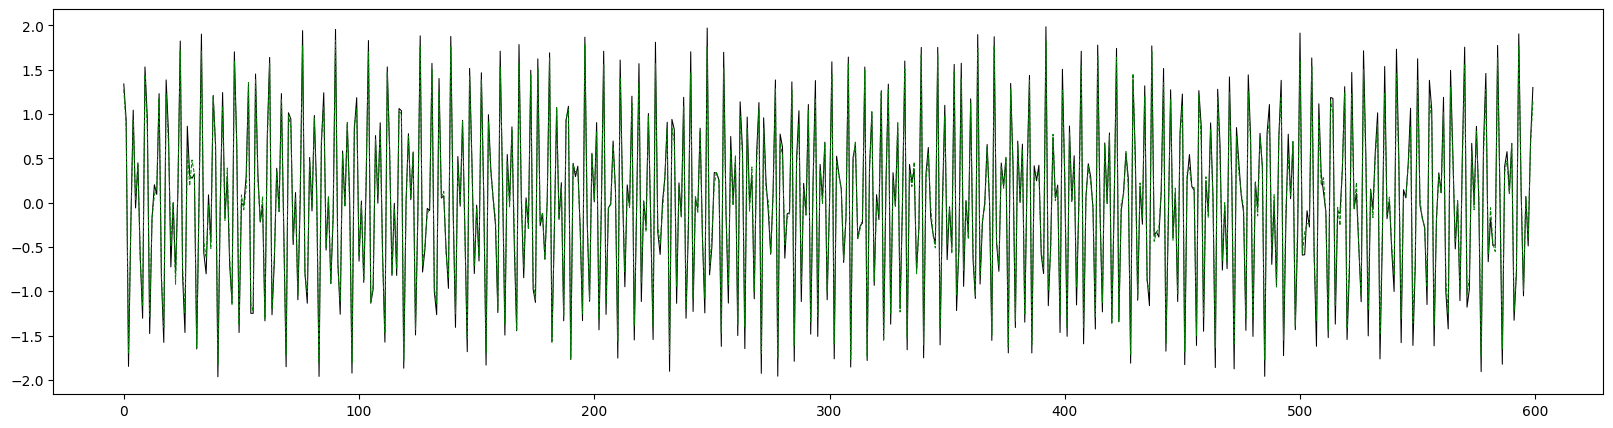

In [81]:
print(10*np.log10(np.sum(signal_noiseless**2)/np.sum((signal_noiseless-xr[0]**2))))
fig, ax = plt.subplots(1,1, figsize = (20,5))
ax.plot(signal_noiseless[200:800],'k', linewidth=0.75)
ax.plot(xr[0][200:800], '--g', linewidth=0.75)


In [88]:
r = np.corrcoef(signal_noiseless, xr[0])[0, 1]

print(f"Coeficiente de correlación de Pearson: {r:.4f}")

Coeficiente de correlación de Pearson: 0.9965-0.0000j


In [93]:
r2 = np.corrcoef(x1, xr[2])[0, 1]

print(f"Coeficiente de correlación de Pearson: {r2:.4f}")

Coeficiente de correlación de Pearson: 0.9967-0.0000j


In [95]:
r3 = np.corrcoef(x2, xr[1])[0, 1]

print(f"Coeficiente de correlación de Pearson: {r3:.4f}")

Coeficiente de correlación de Pearson: 0.9964-0.0000j


In [100]:
SNRs = [snr for snr in range(-20,25,5)]
reps = 10
QRF = np.zeros((reps,len(SNRs)))

all_signals = [[None for _ in SNRs] for _ in range(reps)]
all_images  = [[None for _ in SNRs] for _ in range(reps)]
all_masks  = [[None for _ in SNRs] for _ in range(reps)]

def qrf(x,xhat):
  return 10*np.log10(np.sum(x**2)/np.sum((x-xhat)**2))

for j in range(reps):
    print(j)
    for i,snr in enumerate(SNRs):
        signal, noise = add_snr(signal_noiseless,snr)
        mask, image, s_r = sam_filtering(signal, mascaras=3, Nfft=N,)
        QRF[j,i] = qrf(signal_noiseless,s_r[0])


        all_signals[j][i] = s_r
        all_images[j][i] = image
        all_masks [j][i] = mask

0
snr_out:-20.0


<ipython-input-100-a04cea6d48dd>:17: ComplexWarning: Casting complex values to real discards the imaginary part
  QRF[j,i] = qrf(signal_noiseless,s_r[0])


snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:5.0
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
1
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:5.0
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
2
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:5.0
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
3
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:5.0
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
4
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:5.0
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
5
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:5.0
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
6
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:5.0
snr_out:9.999999999999998
snr_out:15.0
snr_out:20.0
7
snr_out:-20.0
snr_out:-15.0
snr_out:-10.0
snr_out:-5.0
snr_out:0.0
snr_out:5.0
snr_

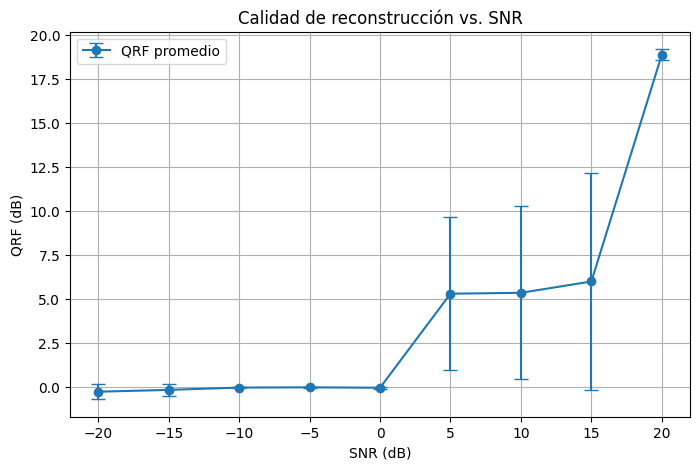

In [103]:
import numpy as np
import matplotlib.pyplot as plt

mean_QRF = np.mean(QRF, axis=0)  # Promedio de QRF sobre las 50 repeticiones
std_QRF = np.std(QRF, axis=0)  # Desviación estándar para ver la dispersión

plt.figure(figsize=(8,5))
plt.errorbar(SNRs, mean_QRF, yerr=std_QRF, fmt='-o', capsize=5, label="QRF promedio")
plt.xlabel("SNR (dB)")
plt.ylabel("QRF (dB)")
plt.title("Calidad de reconstrucción vs. SNR")
plt.grid(True)
plt.legend()
plt.show()

In [102]:
import os
import cv2
import numpy as np


ruta_guardado = "/content/drive/My Drive/SAM/imagenes/"
ruta_mascaras = "/content/drive/My Drive/SAM/mascaras/"
ruta_senales = "/content/drive/My Drive/SAM/senales/"

os.makedirs(ruta_guardado, exist_ok=True)
os.makedirs(ruta_mascaras, exist_ok=True)
os.makedirs(ruta_senales, exist_ok=True)

for i in range(10):
    for j in range(9):
        nombre_archivo = f"imagen_{i}_{j}.png"

        # Guarda la imagen original
        cv2.imwrite(ruta_guardado + nombre_archivo, all_images[i][j])

        # Guarda el array booleano en un archivo .npy
        np.save(ruta_mascaras + f"mascara_{i}_{j}.npy", all_masks[i][j])

        np.save(ruta_senales + f"senal_{i}_{j}.npy", all_signals[i][j])




In [145]:
import numpy as np

# Suponiendo que 'matriz_senales' ya fue cargada y 'senal_sin_ruido' está definida:
# Creamos una matriz para almacenar los coeficientes (50 filas x 9 columnas)
coef_corr = np.zeros((10, 9))
QRF = np.zeros((reps,len(SNRs)))

for i in range(10):
    for j in range(9):
        # Aplanamos ambas señales en caso de que sean arrays multidimensionales
        sr = all_signals[i][j]

        # Calcular la matriz de correlación
        corr_matrix = np.corrcoef(sr[1], x1)
        # Extraemos el coeficiente de correlación (entre 0 y 1, en términos absolutos o no)
        coef_corr[i, j] = corr_matrix[0, 1]
        QRF[i,j] = qrf(signal_noiseless,sr)

# Calcula la media y la desviación estándar a lo largo del eje 0 (50 repeticiones)
mean_corr = np.mean(coef_corr, axis=0)
std_corr = np.std(coef_corr, axis=0)

<ipython-input-145-cff0d21b01a9>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  coef_corr[i, j] = corr_matrix[0, 1]
<ipython-input-145-cff0d21b01a9>:17: ComplexWarning: Casting complex values to real discards the imaginary part
  QRF[i,j] = qrf(signal_noiseless,sr)


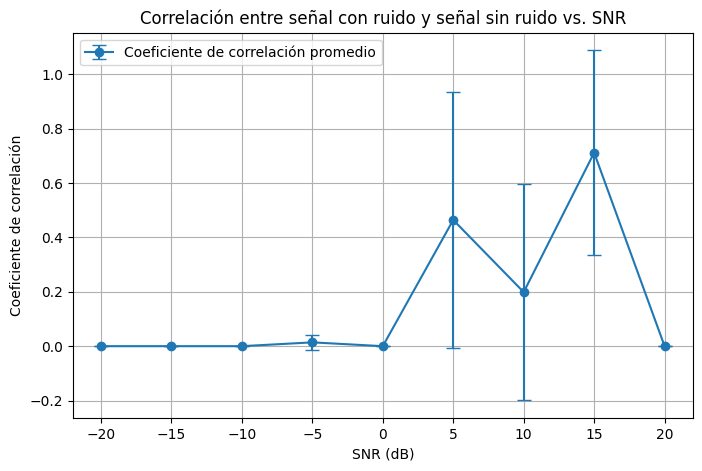

In [146]:
import matplotlib.pyplot as plt


SNRs = [snr for snr in range(-20,25,5)]

plt.figure(figsize=(8, 5))
plt.errorbar(SNRs, mean_corr, yerr=std_corr, fmt='-o', capsize=5, label="Coeficiente de correlación promedio")
plt.xlabel("SNR (dB)")
plt.ylabel("Coeficiente de correlación")
plt.title("Correlación entre señal con ruido y señal sin ruido vs. SNR")
plt.grid(True)
plt.legend()
plt.show()